In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet

from datetime import datetime
from datetime import timedelta

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

import math

In [3]:
import plotly.figure_factory as ff
import statsmodels.api as sm
from scipy.stats import norm

In [4]:
from methods_part2 import *
from methods_forecast import prepare_data, perform_forecast, time_interval

# <center>  Part II : Demand Planning (Inventory) </center> 

<center> 

<img src="data/flow_part2.png">

</center>!

## Load Data

In [116]:
data = pd.read_parquet("data/rossmann_sales.parquet")
data.Date = pd.to_datetime(data.Date)
data.SchoolHoliday = data.SchoolHoliday.astype('int')
data.StateHoliday = data.StateHoliday.replace(['a', 'b', 'c'], 1)
data.StateHoliday = data.StateHoliday.astype('int')

In [117]:
storetype = pd.read_parquet("data/rossmann_area.parquet")
storetype = storetype[['Store', 'StoreType']]

In [118]:
data = data.merge(storetype, on='Store')
items = pd.read_parquet("data/rossmann_items.parquet")
data = data.merge(items, on=['Date', 'Store'])
data.set_index('Date', inplace=True)

<b>Available Data</b>

In [65]:
data.head()

,Store,DayOfWeek,Open,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,itemA,itemB,itemC,itemD,itemE,items
Date,,,,,,,,,,,,,,,
2015-07-31,1,5,1,5263.0,555,1,0,1,c,17,57,90,173,3,357
2015-07-30,1,4,1,5020.0,546,1,0,1,c,17,54,86,165,3,342
2015-07-29,1,3,1,4782.0,523,1,0,1,c,16,52,82,157,2,325
2015-07-28,1,2,1,5011.0,560,1,0,1,c,17,54,86,164,3,341
2015-07-27,1,1,1,6102.0,612,1,0,1,c,20,66,105,200,3,414


## Inventory Planning for Store 122

Goal: Design an inventory/stock plan for the store 122.

Considerations:

- reduce total annual inventory costs.
- reduce number of stockouts.

<b>Inventory Policy : Fixed Order Quantity (s,Q)</b>

The Economic Order Quantity (EOQ, or Q*) is a measurement used in Operations, Logistics, and Supply Management. 
EOQ is a tool used to determine the volume and frequency of orders required to satisfy a given level of demand while minimizing the cost per order. 
It is expresses as:
    $$Q = \sqrt{2Dk/h}$$
 where D is the yearly demand, h is the yearly holding cost and k is the cost of a single transaction.
 
For each item in the different stores we can calcultate the EQO. 

Recall:
- The order quantity Q is fixed for each replenishment order.
- The orders are made on a changing schedule. The ROP (s) determines when an order is placed.

 <b>Understand yearly demand of item A in store number 122.</b>

In [119]:
store = 122
item = 'itemA'
year = 2014
frequency = '2D'

ts1, ts2 = choose_data(data, store, item, year, frequency) 

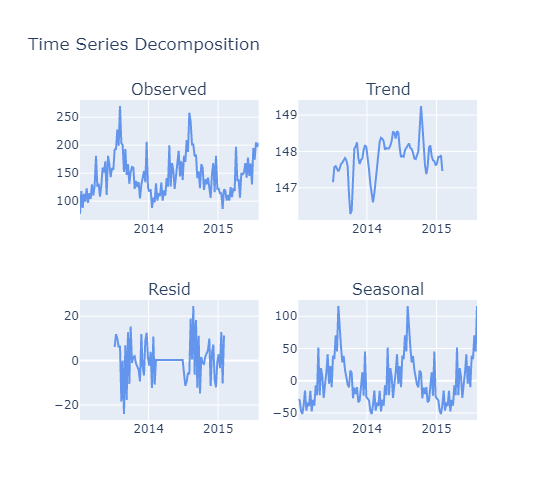

In [69]:
decompose_ts(ts1)

<b>Bussines constrains for item A</b>

In [120]:
#bussines constrains for item A

price = 28.68
lead_time = 6
k = 65.15 # ordering cost  (k: fixed cost of a single transaction)
percentage = 0.1
h = np.round(price*percentage, 2)
time_unit = 7


In [121]:
item , D, EQO, ROP, inv_cost, rp, yearly_demand, hold_cost  = average_demand_item_X(ts2, item, k , price, lead_time, time_unit)

In [122]:
EQO = round_up_EQO(EQO)

In [123]:
print(  '{:*^35}'.format(" SUMMARY ") )
print(  '{:*^35}'.format(f" Store {store} ") )

print("Item ",             '{:>26}'.format(item))
print("Yearly demand(units) ",    '{:>10}'.format(math.ceil(yearly_demand)))
print("period Average demand(units) ",    '{:>1}'.format(math.ceil(D)))
print("Holding Cost, h ($)",    '{:>12}'.format(h))
print("Economic Quantity Order: " , '{:>6}'.format(int(EQO)))
print("ROP (item units):",    '{:>14}'.format(int(ROP)))
#print("Inventory Cost: ", inv_cost)
#print("Best reorder point (days): " , rp)

************* SUMMARY *************
************ Store 122 ************
Item                       itemA
Yearly demand(units)        7715
period Average demand(units)  43
Holding Cost, h ($)         2.87
Economic Quantity Order:     600
ROP (item units):            252


<b> Optimal Replenishment time </b>

Base time \$T_B = 2\$ days. Optimal review period is given by 
$$T^* = \sqrt{2k/(Hd)}$$. 
It is convenient to use the powe-of-2 policy for optimal replenishment. Select the minimn intrger m that satisfies
$$\frac{T^{*}}{\sqrt{2}} < 2^{m}T_B< \sqrt{2} T^{*}$$

In [124]:
ort = optimal_replenishment_time(k, yearly_demand, hold_cost)
print(F"Optimatl replenishment time is : {ort} periods of size 2 ")

Optimatl replenishment time is : 16 periods of size 2 


<b> Reorder Point</b>

In [125]:
print("Average demand: ", D)
rop = np.ceil(lead_time * D)
print(f'Reorder Point: {rop:,.0f} units')

Average demand:  42.16
Reorder Point: 253 units


<b> Get orders</b>

In [126]:

r_frame, stockout_cycle, stockout_period  = get_orders(ts2,'itemA', 122, 150, rop, lead_time, EQO*2, k, yearly_demand, hold_cost , safe = True)

<b> Stockouts</b>

In [127]:
stockouts(r_frame, stockout_period )

Stockouts : 0
num orders : 8


In [78]:
r_frame.head()

,itemA,On-hand,In-transit,OrderSize
Date,,,,
2014-01-01,25,1325,"[0, 0, 0, 0, 0, 0, 1200]",1200
2014-01-03,40,1285,"[0, 0, 0, 0, 0, 1200, 0]",0
2014-01-05,26,1259,"[0, 0, 0, 0, 1200, 0, 0]",0
2014-01-07,42,1217,"[0, 0, 0, 1200, 0, 0, 0]",0
2014-01-09,38,1179,"[0, 0, 1200, 0, 0, 0, 0]",0


In [134]:
SL_alpha_  = SL_alpha(stockout_cycle)
SL_period_ = SL_period(stockout_period, len(r_frame))
print('Cycle Service Level:', SL_alpha_, "%")
print('Period Service Level:',SL_period_,'%')

Cycle Service Level: 100.0 %
Period Service Level: 100.0 %


In [135]:
od = order_dates(r_frame )

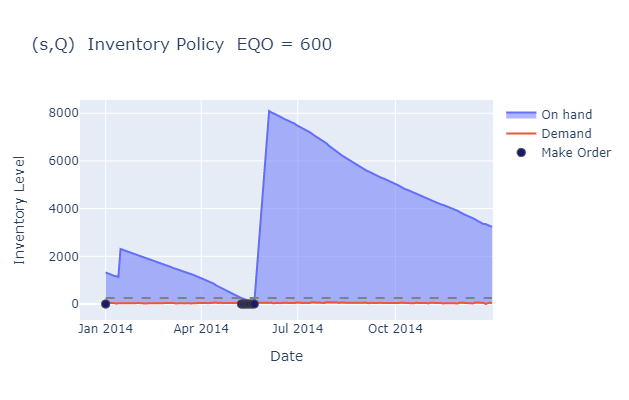

In [136]:
plot_inventory_eqo(r_frame, od, EQO,ROP)

<b>Model Costs</b>

In [137]:
r = get_model_costs(r_frame, k, yearly_demand, hold_cost)
print(f"Cost of Model (EOQ): ${r:,.0f}")

Cost of Model (EOQ): $17,127


## Forcast Demand for year 2015

In [138]:
data_ = prepare_data(data, 122, 'A', frequency)

In [139]:
future_period = 90
r, start, end = perform_forecast(data_, frequency, future_period)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -14.0934
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       919.995    0.00460687       157.506      0.7724      0.7724      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       921.337    0.00093545       105.449   9.436e-06       0.001      191  LS failed, Hessian reset 
     199       921.573   1.23485e-07       92.2963      0.3935      0.3935      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       921.573   1.45152e-08       101.834      0.3924           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Finished calculating Forecast 


Showing only one year of data


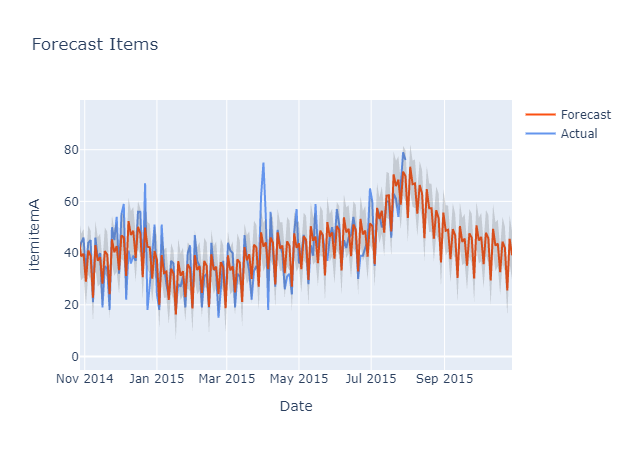

In [140]:
plot_items_individual_store_prediction(r, data_, store , item , "Forecast Items")

<b> What If </b>

In [141]:
forecast_store = r[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'ds': 'Date', 'yhat': 'itemA' })
forecast_store.set_index('Date', inplace=True)

In [142]:
ts1, ts2 = choose_data(data, store, item, year, frequency) 

<b>Inflation  adjustments</b>

- This year inflation yields an inclrement on the price of items of 2.6 %
- Transaction costs increasead 30 % compared to previos year
- Lead time remains the same L = 6

In [143]:
# business constrains
price = price*0.026 + price
lead_time = lead_time
k = k*.30 + k # ordering cost  (k: fixed cost of a single transaction)
percentage = 0.1
h = np.round(price*percentage, 2)
time_unit = 7
year = 2015

In [89]:
forecast_store.head()

,itemA,yhat_lower,yhat_upper
Date,,,
2013-01-01,38.564721,29.358178,48.192266
2013-01-03,35.339674,26.452464,44.972702
2013-01-05,18.244242,9.575397,27.555130
2013-01-07,37.706374,28.445955,46.696427
2013-01-09,31.065516,21.619797,40.267308


In [144]:
tsy2015  = forecast_store[forecast_store.index.year==year][[item]]
tsy2015  = tsy2015 .resample(frequency).sum()

In [145]:
item , D, EQO, ROP, inv_cost, rp, yearly_demand, hold_cost  = average_demand_item_X(tsy2015, item, k , price, lead_time, time_unit)

In [146]:
print(  '{:*^35}'.format(" SUMMARY ") )
print(  '{:*^35}'.format(f" Store {store} ") )

print("Item ",             '{:>26}'.format(item))
print("Yearly demand(units) ",    '{:>10}'.format(math.ceil(yearly_demand)))
print("period Average demand(units) ",    '{:>1}'.format(math.ceil(D)))
print("Holding Cost, h ($)",    '{:>12}'.format(h))
print("Economic Quantity Order: " , '{:>6}'.format(int(EQO)))
print("ROP (item units):",    '{:>14}'.format(int(ROP)))
#print("Inventory Cost: ", inv_cost)
#print("Best reorder point (days): " , rp)

************* SUMMARY *************
************ Store 122 ************
Item                       itemA
Yearly demand(units)        6475
period Average demand(units)  43
Holding Cost, h ($)         2.94
Economic Quantity Order:     611
ROP (item units):            257


In [147]:
ort = optimal_replenishment_time(k, yearly_demand, hold_cost)
print(F"Optimatl replenishment time is : {ort} periods of size 2 ")

Optimatl replenishment time is : 16 periods of size 2 


In [148]:
print("Average demand: ", D)
rop = np.ceil(lead_time * D)
print(f'Reorder Point: {ROP:,.0f} units')

Average demand:  42.88
Reorder Point: 257 units


In [149]:
# get orders
r_frame, stockout_cycle, stockout_period  = get_orders(tsy2015,'itemA', 122, 150, ROP, lead_time, EQO*2, k, yearly_demand, hold_cost , safe = True)

In [150]:
stockouts(r_frame, stockout_period )

Stockouts : 1
num orders : 8


In [151]:
SL_alpha_  = SL_alpha(stockout_cycle)
SL_period_ = SL_period(stockout_period, len(r_frame))
print('Cycle Service Level:', SL_alpha_, "%")
print('Period Service Level:',SL_period_,'%')

Cycle Service Level: 87.5 %
Period Service Level: 99.3 %


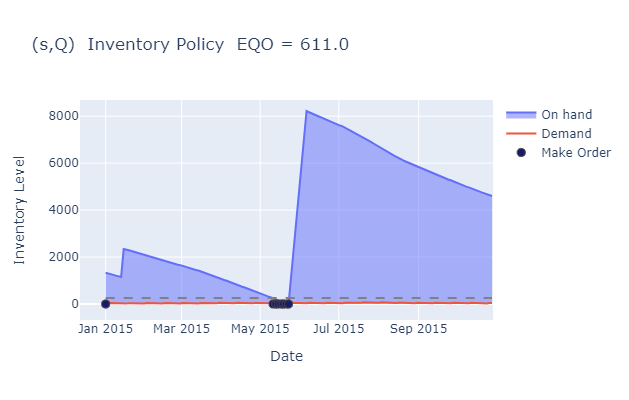

In [152]:
od = order_dates(r_frame)
plot_inventory_eqo(r_frame, od, EQO,ROP)

In [ ]:
def plot_inventory_eqo(df, orders, eqo, rop):

    fig = go.Figure()
    fig.add_trace(go.Scatter(x= df.index, y=df['On-hand'], name = 'On hand', fill = 'tozeroy'))
    fig.add_trace(go.Scatter(x= df.index, y=df['itemA'], name = 'Demand'))
    #fig = px.line(x=orders_df.index, y=orders_df['On-hand'], fill = 'tozeroy')
    fig.add_trace(go.Scatter(x = orders,
                         y = [0]*len(orders) , 
                          marker = {"color":["MidnightBlue"]*len(df), "line":{"width":1}, "size":8},
                          mode = "markers+text",
                          name = 'Make Order',
                          #showlegend = False,
                          #text = ocasion, 
                          textposition = "top center"))
    #fig.add_shape(type = 'line', x0 =  '2015-01-02', x1 = '2015-01-02', y0 = 0 ,     y1= ROP , xref='x', yref='y',line = dict(color = 'blue', dash = 'dash'))
    #fig.add_shape(type = 'line', x0 =  '2015-01-02', x1 = '2015-01-02', y0 = Ss +Cs, y1=  S , xref='x', yref='y',line = dict(color = 'blue', dash = 'dash'))
    fig.add_shape(type = 'line', x0 =  df.index[0], x1 = df.index[len(df)-1],
                                 y0 =  rop,          y1=  rop , xref='x', yref='y',line = dict(color = 'grey', dash = 'dash'))

    # fig.add_hrect(y0=Ss, y1=Ss+Cs, 
    #               annotation_text="Cycle Stock", annotation_position="top right",
    #               fillcolor="green", opacity=0.15, line_width=0)
    # fig.add_hrect(y0=0, y1=Ss, 
    #               annotation_text="Safety Stock", annotation_position="top right",
    #               fillcolor="orange", opacity=0.15, line_width=0)


    fig.update_layout(xaxis_title = "Date",
                  yaxis_title = 'Inventory Level',
                  title = " (s,Q)  Inventory Policy  EQO = "+str(EQO) ,
                  height = 400)
    return fig

In [153]:
r = get_model_costs(r_frame, k, yearly_demand, hold_cost)

print(f"Cost of Model (EOQ): ${r:,.0f}")

Cost of Model (EOQ): $17,961


<b> Observations</b>

- We have analised  two consecutive years 2014 and 2015. 
- Year 2014 has complete data and it serves as benchmark year.
- Year 2015 has data up to July 30th. We forecast the demand for the next 3 months.
- If the EQO policy is applied then consecutives ordes should have to be done in the months of may anmd June to reach enough inventory for the rest of the year. 
- Backdraw:  when the ROP is reached  the first order is made but inventory level keeps droping until we have a stockput because the order could not arrive in time. 
- Orders keep coming because minimun  inventory levels haven't been reached
- As a result the orders pile up and the ond hand inventory is to high. Physcial limits can impose a constrain in the quentitty of items that can be stored.
- another backdraw is tah cycle srvice level and period service level decreased compared to last year.
-  It is recomended change inventory policy or reduce the lead time.

<b>Strategy: Reduce lead time by one period</b>

In [154]:
# business constrains
price = price
lead_time = 5
k =  k # ordering cost  (k: fixed cost of a single transaction)
h = h
time_unit = 7

In [155]:
item , D, EQO, ROP, inv_cost, rp, yearly_demand, hold_cost  = average_demand_item_X(tsy2015, item, k , price, lead_time, time_unit)

In [156]:
EQO = round_up_EQO(EQO)

In [157]:
print(  '{:*^35}'.format(" SUMMARY ") )
print(  '{:*^35}'.format(f" Store {store} ") )

print("Item ",             '{:>26}'.format(item))
print("Yearly demand(units) ",    '{:>10}'.format(math.ceil(yearly_demand)))
print("period Average demand(units) ",    '{:>1}'.format(math.ceil(D)))
print("Holding Cost, h ($)",    '{:>12}'.format(h))
print("Economic Quantity Order: " , '{:>6}'.format(int(EQO)))
print("ROP (item units):",    '{:>14}'.format(int(ROP)))
#print("Inventory Cost: ", inv_cost)
#print("Best reorder point (days): " , rp)

************* SUMMARY *************
************ Store 122 ************
Item                       itemA
Yearly demand(units)        6475
period Average demand(units)  43
Holding Cost, h ($)         2.94
Economic Quantity Order:     700
ROP (item units):            214


In [158]:
ort = optimal_replenishment_time(k, yearly_demand, hold_cost)
print(F"Optimatl replenishment time is : {ort} periods of size 2 ")

Optimatl replenishment time is : 16 periods of size 2 


In [159]:
print("Average demand: ", D)
rop = np.ceil(lead_time * D)
print(f'Reorder Point: {ROP:,.0f} units')

Average demand:  42.88
Reorder Point: 214 units


In [160]:
# get orders
r_frame, stockout_cycle, stockout_period  = get_orders(tsy2015,'itemA', 122, 150, ROP, lead_time, EQO*2, k, yearly_demand, hold_cost , safe = True)

In [161]:
stockouts(r_frame, stockout_period )

Stockouts : 1
num orders : 7


In [60]:
#r_frame[r_frame['On-hand']< ROP]
#r_frame[r_frame['OrderSize']>0 ]

In [162]:
SL_alpha_  = SL_alpha(stockout_cycle)
SL_period_ = SL_period(stockout_period, len(r_frame))
print('Cycle Service Level:', SL_alpha_, "%")
print('Period Service Level:',SL_period_,'%')

Cycle Service Level: 85.7 %
Period Service Level: 99.3 %


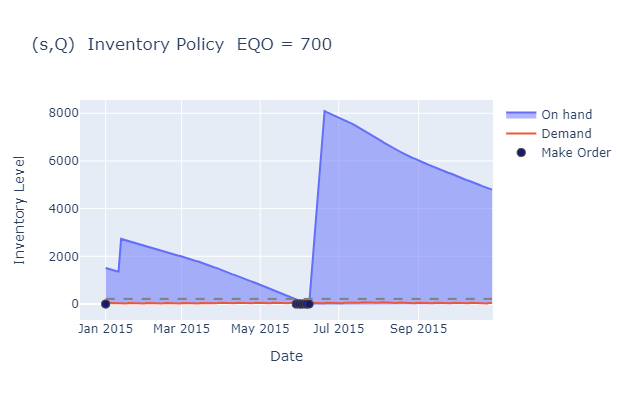

In [163]:
od = order_dates(r_frame)
plot_inventory_eqo(r_frame, od, EQO,ROP)

In [164]:
r = get_model_costs(r_frame, k, yearly_demand, hold_cost)
print(f"Cost of Model (EOQ): ${r:,.0f}")

Cost of Model (EOQ): $17,148


<b> Observations</b>

- By reducing the lead time, the total costs decreased by 2000
- Number of orders decreased by one.
- On hand inventory drecreases but it is still very high in the days after the stockout when all the incoming orders pile up.
- There is still one stockout
- Cycle Service Level decresead

__Results:__

| Plan         |  lead time  | Stockouts | Placed Orders | Inventory Cost  | 
| :---          | :---:       | :---:     | ---:          | ---:            | 
| Benchmark(2014)|       6      | 0         | 8            | \$ 17,127    |
| Plan A  (2015) |       6     |1         | 8           | \$ 17,961    | 
| Plan B   (2015)|      5      |1         | 7            | \$ 17,148    | 

Manager should decide if saving ~$800 is a better option compared to the option of plan A where an extra order should be made.
In both plans the hand on inventory is very elevated when the incoming orders pile up.

# Up to here!

## Methods

In [67]:
def decompose_ts(data):

    decomposition = sm.tsa.seasonal_decompose(data)
    
    fig = make_subplots(rows=2, cols=2, subplot_titles=("Observed", "Trend", "Resid", "Seasonal"))
    # Observed or Actual values
    fig.add_trace(go.Scatter(x=decomposition.observed.index, 
                             y=decomposition.observed.values, 
                             marker_color='cornflowerblue',
                             hovertemplate="Date: %{x} <br>" + "Net Sales: $ %{y}"), row=1, col=1)
    # Trend decomposition
    fig.add_trace(go.Scatter(x=decomposition.trend.index, 
                             y=decomposition.trend.values,
                             marker_color='cornflowerblue',
                             hovertemplate="Date: %{x} <br>" + "Net Sales: $ %{y}"), row=1, col=2)
    # Residuals
    fig.add_trace(go.Scatter(x=decomposition.resid.index, 
                             y=decomposition.resid.values, 
                             marker_color='cornflowerblue',
                             hovertemplate="Date: %{x} <br>" + "Net Sales: $ %{y}"), row=2, col=1)
    # Seasonal decomposition
    fig.add_trace(go.Scatter(x=decomposition.seasonal.index, 
                             y=decomposition.seasonal.values, 
                             marker_color='cornflowerblue',
                             hovertemplate="Date: %{x} <br>" + "Net Sales: $ %{y}"), row=2, col=2)
    fig.update_layout(height=500, 
                      autosize=True,
                      title_text="Time Series Decomposition",
                      showlegend=False)
    return fig

In [35]:
# def optimal_replenishment_time(fixed_transaction_cost: float, 
#                                    yearly_demand: float, 
#                                    holding_cost: float):
#     D = yearly_demand
#     h = holding_cost # Get yearly holding cost
#     k = fixed_transaction_cost # Get transaction cost
    
#     # Get the optimal review time. This is given as percentage of a year and Match it with the base time
#     t = np.sqrt((2 * k)/ (h * D)) * 183
    
#     # Get the review period in power of two
#     lower_time = t / np.sqrt(2) 
#     upper_time = t * np.sqrt(2)

#     powers = []
#     for m in range(0, 10):
#         testing = (2**m)*1
#         if lower_time <=  testing and  testing <= upper_time:
#             powers.append(m)
#         else:
#             pass

#     min_power = min(powers)
#     optimal_replenishment_time = 2**min_power * 1
     
#     return optimal_replenishment_time

In [68]:

def plot_items_individual_store_prediction(df_forecast, df_sales, store, feature, title_):
    
    start, end = time_interval(df_forecast)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x = df_sales['ds'],   y = df_sales['y']     , name = "Actual",   hovertemplate="items: %{y:,.0f}" , mode = 'lines', line =dict(color="#6495ed")))
    fig.add_trace(go.Scatter(x = df_forecast.ds,   y = df_forecast.yhat  , name = "Forecast", hovertemplate="items: %{y:,.0f}" , mode = 'lines', line =dict(color="#fb5012")))
    fig.add_trace(go.Scatter(x = df_forecast.ds,   y = df_forecast.yhat_upper , mode = 'lines', line = dict(width = 0), hoverinfo = "skip", showlegend = False, name = "Upper" ))
    fig.add_trace(go.Scatter(x = df_forecast.ds,   y = df_forecast.yhat_lower , mode = 'lines', line = dict(width = 0) , fillcolor= 'rgba(68,68,68, 0.2)', fill = "tonexty", hoverinfo = "skip", showlegend = False, name = "Upper" ))

    fig.update_layout(xaxis_title = "Date",
                      yaxis_title = 'item' + str(feature),
                      #title = "Forecast: open on sundays - Store no. " + str(store),
                      height = 450,
                      title = title_,
                      hovermode = "x",
                      xaxis_range = [start, end]   )

    print("Showing only one year of data")

    return fig